In [11]:
from PIL import Image, ImageOps
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
#Transformada de Fourier
from scipy.fft import fft, fft2, fftfreq, ifft
#Funçoes Auxiliares
from PIL_Functions import img_to_matrix, soma_linhas
#Ouvir a Cena
from scipy.interpolate import interp1d

In [12]:
# DESCOMENTAR NO FIM PARA GRAVAR PLOTS EM LATEX. DEMORAM MAIS A GERAR
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.linewidth'] = 1.5

In [13]:
def imita(matrix):
    new_matrix = list()
    linha      = list()
    for i in matrix:
        for j in i:
            linha.append(j)
        new_matrix.append(linha)
        linha=list()
    return new_matrix
    
    

def threshold(matrix, t, color, ylim_cima=0, ylim_baixo=1023, save_bkg=False):
    new_matrix = imita(matrix)
    
    if(save_bkg):
        bkg    = imita(matrix)
    
    width = len(matrix[0])
    height= len(matrix)
    
    for linha in range(height):
        for coluna in range(width):
            if new_matrix[linha][coluna] <= t or linha<ylim_cima or linha>ylim_baixo:
                new_matrix[linha][coluna] = color
            else:
                if save_bkg:
                    bkg[linha][coluna] = color
    if save_bkg:
        return new_matrix, bkg
    return new_matrix



def integrate(linha):
    integral = 0
    for i in linha:
        integral += i
    return integral



def normalize(linha, maximo=False):
    if (maximo != False):
        return [i/maximo for i in linha]
    else:
        maximo = max(linha)
        return [i/maximo for i in linha]



def get_region(x, y, borders):
    x_reg = list()
    y_reg = list()
    assert(len(x) == len(y))
    for i in range(len(y)):
        if x[i] >= borders[0] and x[i] <= borders[1]:
            x_reg.append(x[i])
            y_reg.append(y[i])
    return x_reg, y_reg
   
    
    
def crop(matrix, x_reg, y_reg):
    new_matrix = matrix[y_reg[0]:y_reg[1]][x_reg[0]:x_reg[1]].copy()
    return new_matrix



def centroid(data_x, data_y):
    termos = [x * y for x, y in zip(data_x, normalize(data_y, sum(data_y)))]
    soma = 0
    
    for termo in termos:
        soma+= termo
    return soma

def get_harmonico(freq):
    return freq*800e-9/c

def print_tabular(HH_freq, LaTeX):
    if (LaTeX):
        tabular = r"\begin{tabular}{|c|c|c|}\n \hline Pico $\#$ & Frequência $\pm 0.05$ (PHz) & Harmónica \\" + '\n'

        for i in range(len(HH_freq)):
            tabular += r"\hline {:} & ${:.2e}$ & {:} \\".format(i+1, HH_freq[i], round(get_harmonico(HH_freq[i]), 2)) + '\n'

        tabular += r"\hline" + '\n' + r"\end{tabular}"
    else:
        tabular = str()
        for i in range(len(HH_freq)):
            if (i != 9):
                tabular += 'Pico ' + str(i + 1) + ':  ' + str("{:.2e}".format(HH_freq[i])) + ' Hz  --->  Harmónico: ' + str(round(get_harmonico(HH_freq[i]), 2)) + '\n'
            else:
                tabular += 'Pico ' + str(i + 1) + ': '  + str("{:.2e}".format(HH_freq[i])) + ' Hz  --->  Harmónico: ' + str(round(get_harmonico(HH_freq[i]), 2)) + '\n'
    print(tabular)

## Determinação do tempo de aquisição ótimo

In [14]:
path_imagens = '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Dados/4a sessao/KRIPTON/fendas/bkg_removed_images/'
paths        = [path_imagens + str(i + 1) + 's.tif' for i in range(7)]
paths.insert(0, path_imagens + '0.5s.tif')

In [15]:
images = [Image.open(i) for i in paths]
matrxs = [img_to_matrix(i) for i in images]

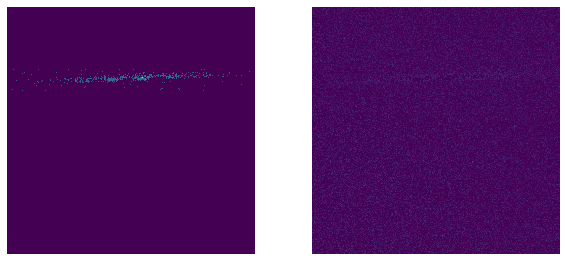

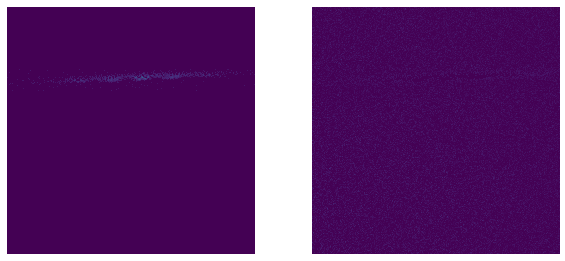

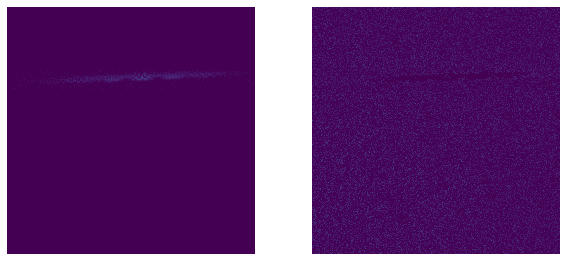

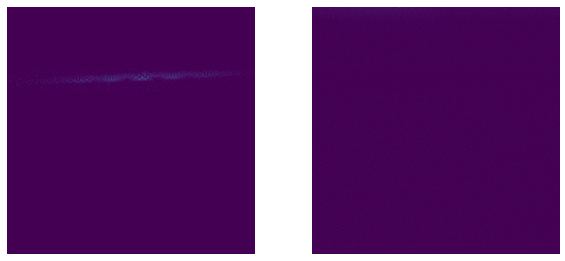

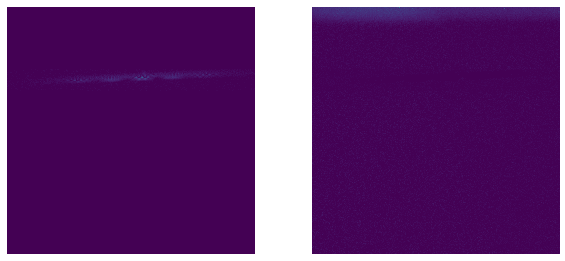

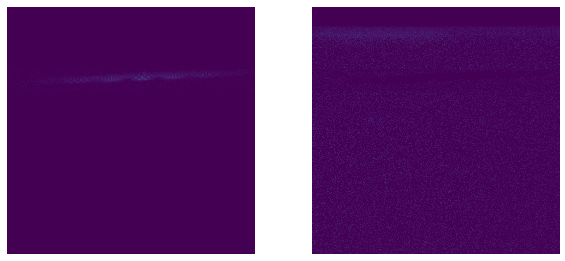

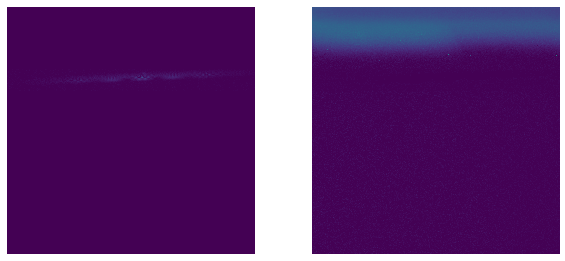

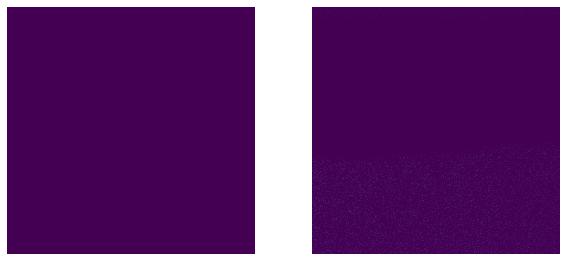

In [16]:
linhas = list()
racios = list()
t_val  = [20, 20, 20, 20, 20, 20, 24, 350]
t_val  = [20, 20, 20, 20, 20, 20, 20, 250]

for i in range(len(matrxs)):
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    
    new_matrix, bkg = threshold(matrxs[i], t = t_val[i], color = 0, ylim_cima=260, ylim_baixo=350, save_bkg=True) #105 uma delas fica cute
    
    
    ax1.imshow(new_matrix)
    ax2.imshow(bkg)
    
    for ax in [ax1, ax2]:
        ax.axis(False)
        
    racios.append(integrate(soma_linhas(new_matrix))/integrate(soma_linhas(bkg)))
    linhas.append(soma_linhas(new_matrix))

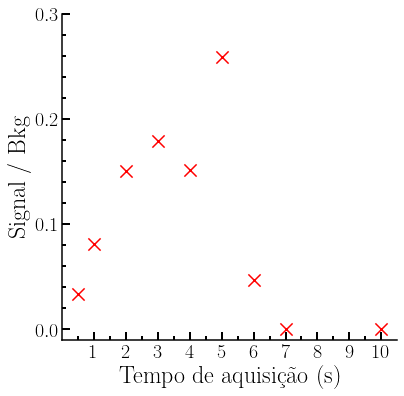

In [25]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

r = racios + [0]
ax.scatter([0.5, 1, 2, 3, 4, 5, 6, 7, 10], r, color='red', s=150, marker='x')
ax.plot()

ax.set_xlabel(r'Tempo de aquisição (s)')
ax.set_ylabel(r'Signal / Bkg')

###### ESTÉTICAS ######

ax.xaxis.set_tick_params(which='major', size=8, width=2,  direction='in')
ax.xaxis.set_tick_params(which='minor', size=4, width=2,  direction='in')
ax.yaxis.set_tick_params(which='major', size=8, width=2, direction='in')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim(-0.01, 0.3)


plt.savefig('Kr_racios.pdf', bbox='tight_layout')

In [28]:
path = '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Dados/4a sessao/KRIPTON/fendas/bkg_removed_images/5s_rotated.tif'
img  = Image.open(path)

matrix, bkg = threshold(img_to_matrix(img), t = 35, color = 0, ylim_cima=265, ylim_baixo=315, save_bkg=True)

# Separação do Espectro obtido nas suas 3 componentes

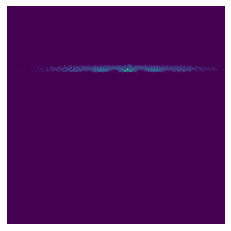

In [29]:
plt.imshow(matrix)
plt.axis(False)
plt.show()

plt.imsave('full_espectro.png', np.array(matrix))

In [68]:
cropped = crop(matrix, [0, len(matrix)], [265, 315])

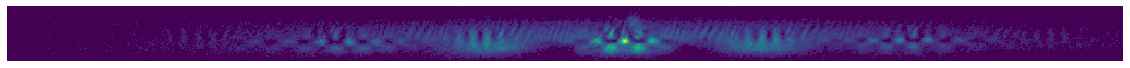

In [70]:
fig = plt.figure(figsize=(20, 20))

plt.imshow(cropped)
plt.axis(False)
plt.show()

plt.imsave('full_espectro.png', np.array(cropped))

In [32]:
linha3 = crop(cropped, [0, len(matrix)], (0, 20))

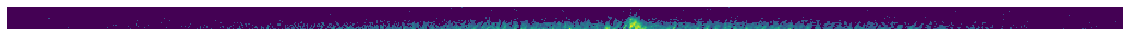

In [33]:
fig = plt.figure(figsize=(20, 20))

plt.imshow(linha3)
plt.axis(False)
plt.show()

In [34]:
linha2 = crop(cropped, [0, len(matrix)], [21, 33])

In [35]:
fig = plt.figure(figsize=(20, 20))

plt.imshow(linha2)
plt.axis(False)
plt.show()

In [36]:
linha1 = crop(cropped, [0, len(matrix)], [33, len(cropped) - 7])

In [37]:
fig = plt.figure(figsize=(20, 20))

plt.imshow(linha1)
plt.axis(False)
plt.show()

In [38]:
#CONSTANTES
d       = 100e-6 #Distância entre fendas
delta_x = 13e-6  #Fator de conversão
z       = 40e-2  #Distância ao CCD
N       = 1024   #Pixeis
c       = 299792458

SAMPLE_RATE = (c * z)/(N * d * delta_x) # AINDA NÃO ESTOU SEGURO DA FÓRMULA

In [39]:
def f_n(pixel):
    return (pixel * c * z)/(N * d * delta_x)

In [40]:
hist1 = soma_linhas(linha1)
hist2 = soma_linhas(linha2)
hist3 = soma_linhas(linha3)

hist1f = np.abs(fft(hist1))
hist2f = np.abs(fft(hist2))
hist3f = np.abs(fft(hist3))

\begin{tabular}{|c|c|c|}\n \hline Pico $\#$ & Frequência $\pm 0.05$ (PHz) & Harmónica \\
\hline 1 & $5.91e+15$ & 15.77 \\
\hline 2 & $6.62e+15$ & 17.66 \\
\hline 3 & $7.31e+15$ & 19.5 \\
\hline 4 & $8.00e+15$ & 21.35 \\
\hline 5 & $8.75e+15$ & 23.34 \\
\hline
\end{tabular}


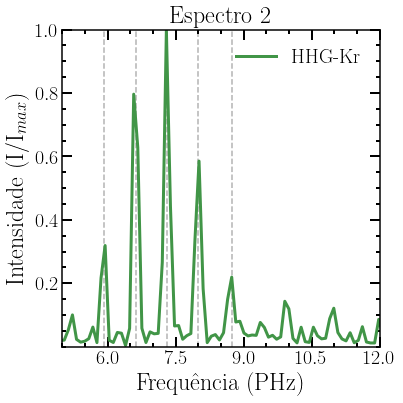

In [62]:
#ESPECÍFICO ESPECTRO 2
d   = 100e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15
#PARTE DO PLPOT
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

#A DETERMINAÇÃO DESTES VALORES TEM DE SER FEITA À MÃO
a0, b0 = 4, 12 # PICO 0

a1, b1 = 64, 68 # PICO 1
a2, b2 = 71, 77  # PICO 2
a3, b3 = 79, 84 # PICO 3
a4, b4 = 87, 92 # PICO 4
a5, b5 = 94, 101 # PICO 5

#a6, b6 = 155, 161 # PICO 6
#a7, b7 = 165, 173 # PICO 7
#
#a8 , b8  = 222, 227  # PICO 8 
#a9 , b9  = 241, 246 # PICO 9 
#a10, b10 = 261, 265 # PICO 10

picos = [#(a0, b0),
         (a1, b1),
         (a2, b2),
         (a3, b3),
         (a4, b4),
         (a5, b5)]

#PLOT DO ESPECTRO
ax.plot(x_f[4:int(1024/2)], normalize(hist2f[4:int(1024/2)]), '-', lw=3, label='HHG-Kr', color='#419547')
#HIGHLIGHT DOS HARMÓNICOS
#ax.plot(x_f[a0:b0], normalize(hist2f[a0:b0], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a1:b1], normalize(hist2f[a1:b1], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2, label='Picos')
#ax.plot(x_f[a2:b2], normalize(hist2f[a2:b2], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a3:b3], normalize(hist2f[a3:b3], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a4:b4], normalize(hist2f[a4:b4], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a5:b5], normalize(hist2f[a5:b5], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#
#ax.plot(x_f[a6:b6], normalize(hist2f[a6:b6], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a7:b7], normalize(hist2f[a7:b7], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#
#ax.plot(x_f[a8:b8]  , normalize(hist2f[a8:b8]  , max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a9:b9]  , normalize(hist2f[a9:b9]  , max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a10:b10], normalize(hist2f[a10:b10], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#PLOT DA LINHA VERTICAL QUE PASSA NO CENTROIDE

HH_freq = list()
for pico in picos:
    HH_freq.append(centroid(x_f[pico[0]:pico[1]], hist2f[pico[0]:pico[1]]))
    plt.vlines(HH_freq[-1], 0, 1, linestyles='--', alpha = 0.3)

ax.set_xlabel('Frequência (PHz)')
ax.set_ylabel('Intensidade (I/I$_{max}$)')
ax.set_title('Espectro 2')
ax.legend(loc='upper right', frameon=False)

ax.set_xlim(5, 12)
ax.set_ylim(0, 1)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')

ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))

ax.yaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
        
print_tabular(np.array(HH_freq)*1e15, LaTeX=True) #LaTeX = True ---> LaTeX print

fig.set_tight_layout(True)
plt.savefig('kr_spec2.pdf', bbox='tight_layout')

\begin{tabular}{|c|c|c|}\n \hline Pico $\#$ & Frequência $\pm 0.05$ (PHz) & Harmónica \\
\hline 1 & $7.30e+15$ & 19.48 \\
\hline
\end{tabular}


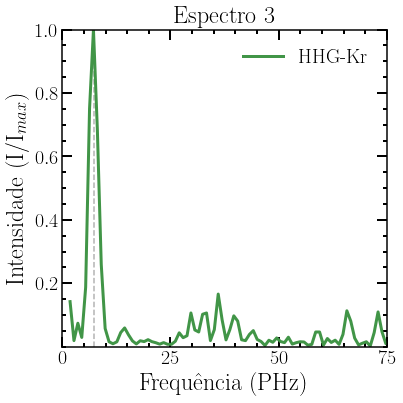

In [63]:
#ESPECÍFICO ESPECTRO 2
d   = 10e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15
#PARTE DO PLPOT
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

#A DETERMINAÇÃO DESTES VALORES TEM DE SER FEITA À MÃO
a1, b1 = 5, 14 # PICO 1
#a2, b2 = 16, 26 # PICO 1
# ...
picos = [(a1, b1 )]

#PLOT DO ESPECTRO
ax.plot(x_f[2:int(1024/2)], normalize(hist1f[2:int(1024/2)]), '-', lw=3, label='HHG-Kr', color='#419547')
#HIGHLIGHT DOS HARMÓNICOS
#ax.plot(x_f[a1:b1], normalize(hist1f[a1:b1], max(hist1f[2:int(1024/2)])), '-', color = 'salmon', lw=2, label='Picos')
#ax.plot(x_f[a2:b2], normalize(hist1f[a2:b2], max(hist1f[2:int(1024/2)])), '-', color = 'salmon', lw=2, label='Picos')

#PLOT DA LINHA VERTICAL QUE PASSA NO CENTROIDE

HH_freq = list()
for pico in picos:
    HH_freq.append(centroid(x_f[pico[0]:pico[1]], hist2f[pico[0]:pico[1]]))
    plt.vlines(HH_freq[-1], 0, 1, linestyles='--', alpha = 0.3)

ax.set_xlabel('Frequência (PHz)')
ax.set_ylabel('Intensidade (I/I$_{max}$)')
ax.set_title('Espectro 3')
ax.legend(loc='upper right', frameon=False)
#
ax.set_xlim(0, 75)
#ax.set_xlim(7, 11)
ax.set_ylim(0, 1)
#
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
#
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')
#
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
#
ax.yaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
#        
print_tabular(np.array(HH_freq)*1e15, LaTeX=True) #LaTeX = True ---> LaTeX print

fig.set_tight_layout(True)
plt.savefig('kr_spec3.pdf', bbox='tight_layout')

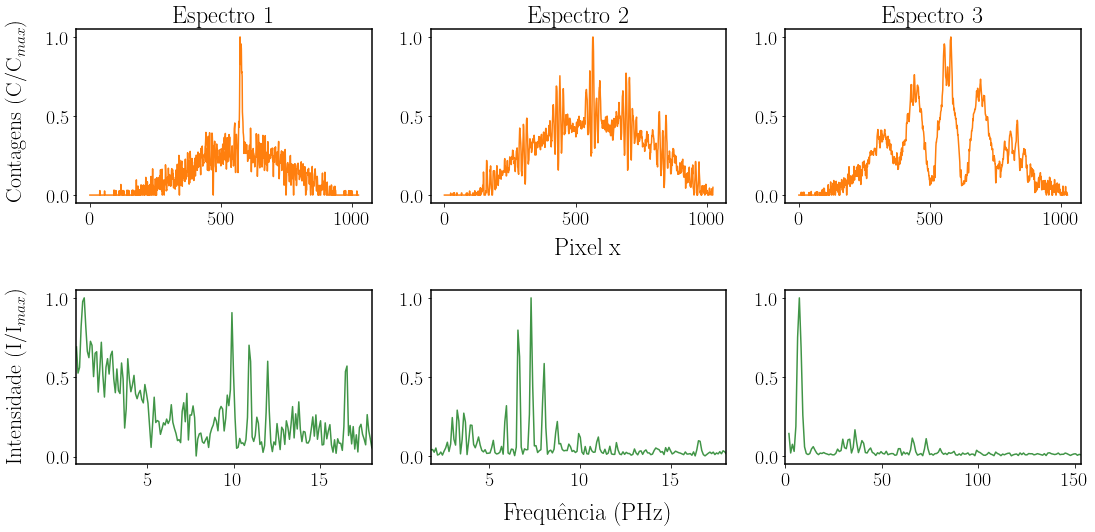

In [61]:
fig = plt.figure(figsize=(18, 8))

#ESPECÍFICO ESPECTRO 2
d   = 100e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15

#Sinal
ax1  = fig.add_subplot(2, 3, 1)
ax2  = fig.add_subplot(2, 3, 2)
ax3  = fig.add_subplot(2, 3, 3)
#Transfomada
ax1f = fig.add_subplot(2, 3, 4)
ax2f = fig.add_subplot(2, 3, 5)
ax3f = fig.add_subplot(2, 3, 6)

ax1.set_title('Espectro 1')
ax1.plot(normalize(hist3), color='C1')

ax2.set_title('Espectro 2')
ax2.plot(normalize(hist2), color='C1')

ax3.set_title('Espectro 3')
ax3.plot(normalize(hist1), color='C1')

ax1f.plot(x_f[10:int(1024/2)], normalize(hist3f[10:int(1024/2)]), color='#419547')
ax2f.plot(x_f[10:int(1024/2)], normalize(hist2f[10:int(1024/2)]), color='#419547')

ax1f.set_xlim(x_f[10], x_f[200])
ax2f.set_xlim(x_f[20], x_f[200])

#ESPECÍFICO ESPECTRO 3

d   = 10e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15
ax3f.plot(x_f[2:int(1024/2)], normalize(hist1f[2:int(1024/2)]), color='#419547')

axis = [ax1, ax2, ax3, ax1f, ax2f, ax3f]
#for ax in axis:
#    ax.axis(False)
ax3f.set_xlim(0, x_f[170])

plt.subplots_adjust(hspace = 0.5) 

fig.text(0.52, 0.5, 'Pixel x', ha='center', va='center', fontsize=24)
fig.text(0.52, 0.04, 'Frequência (PHz)', ha='center', va='center', fontsize=24)

fig.text(0.08, 0.28, 'Intensidade (I/I$_{max})$', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(0.08, 0.74, 'Contagens (C/C$_{max})$', ha='center', va='center', rotation='vertical', fontsize=22)
    
fig.savefig('Kr_Specs.pdf', bbox='tight_layout')